In [1]:
%reload_ext autoreload
%autoreload 2

In [33]:
import os
import logging
from pathlib import Path

import arviz as az
import pandas as pd
import numpy as np
import numpyro

from hb_mep.config import HBMepConfig
from hb_mep.data_access import DataClass
from hb_mep.models.relu import ReLU
from hb_mep.models.human.rectified_logistic import RectifiedLogistic
from hb_mep.models.human.saturated_relu import SaturatedReLU
from hb_mep.models.human.generalized_logistic import GeneralizedLogistic
from hb_mep.utils import plot

numpyro.set_platform("cpu")
numpyro.set_host_device_count(12)
numpyro.enable_x64()

PARENT_PATH = Path(os.getcwd()).parent.parent.absolute()
FORMAT = "%(asctime)s - %(name)s - %(levelname)s - %(message)s"
logging.basicConfig(format=FORMAT, level=logging.INFO)

#### Load config

In [3]:
config = HBMepConfig()
config.CURRENT_PATH = PARENT_PATH

#### Load data and preprocess

In [4]:
data = DataClass(config)

DATASET_REAL = 'real_data/dnc_info_2022-05-26.parquet'
DATASET_REAL_METADATA = 'dnc_info_2022-05-26_settings.json'

df = pd.read_parquet(os.path.join(data.data_path, DATASET_REAL))
df = data.clean_human_data(df)

# participants = ["cornptio012", "cornptio013", "cornptio015", "scapptio001"]
# idx = df.participant.isin(participants)
# df = df[idx].reset_index(drop=True).copy()

df, encoder_dict = data.build(df)

2023-05-25 13:10:11,471 - hb_mep.utils.utils - INFO - func:clean_human_data took: 0.11 sec
2023-05-25 13:10:11,473 - hb_mep.data_access.core - INFO - Processing data ...
2023-05-25 13:10:11,482 - hb_mep.utils.utils - INFO - func:preprocess took: 0.01 sec
2023-05-25 13:10:11,482 - hb_mep.utils.utils - INFO - func:build took: 0.01 sec


### Rectified Linear

#### Initialize model

In [5]:
model_relu = ReLU(config)

#### Run MCMC inference

In [6]:
mcmc_relu, posterior_samples_relu = model_relu.run_inference(df=df)

2023-05-25 12:42:12,042 - jax._src.xla_bridge - INFO - Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
2023-05-25 12:42:12,042 - jax._src.xla_bridge - INFO - Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023-05-25 12:42:12,042 - jax._src.xla_bridge - INFO - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023-05-25 12:42:12,043 - jax._src.xla_bridge - INFO - Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
2023-05-25 12:42:12,043 - jax._src.xla_bridge - INFO - Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.
2023-05-25 12:42:12,077 - hb_mep.models.relu - INFO - Running inference with ReLU ...


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

#### Diagnostics

In [ ]:
mcmc_relu.print_summary(prob=.95)


                             mean       std    median      2.5%     97.5%     n_eff     r_hat
                 a[0,0]      0.98      0.87      0.82      0.00      2.19   1662.46      1.00
                 a[0,1]      1.10      0.15      1.11      0.80      1.39   6091.38      1.00
                 a[0,2]      2.78      1.42      3.04      0.00      4.75   2382.16      1.00
                 a[0,3]      3.77      0.31      3.77      3.18      4.39   5101.10      1.00
                 a[0,4]      2.65      0.58      2.57      1.97      3.26    795.81      1.00
                 a[0,5]      4.87      3.47      4.50      0.00     10.28   3054.16      1.00
                 a[0,6]      2.90      0.11      2.91      2.74      3.08   1320.15      1.00
                 a[0,7]      1.44      0.17      1.47      1.03      1.71   4652.63      1.00
                 a[0,8]      1.07      0.33      1.07      0.02      1.62     38.29      1.12
                 a[0,9]      1.99      0.24      1.89      

#### Plot fitted curves

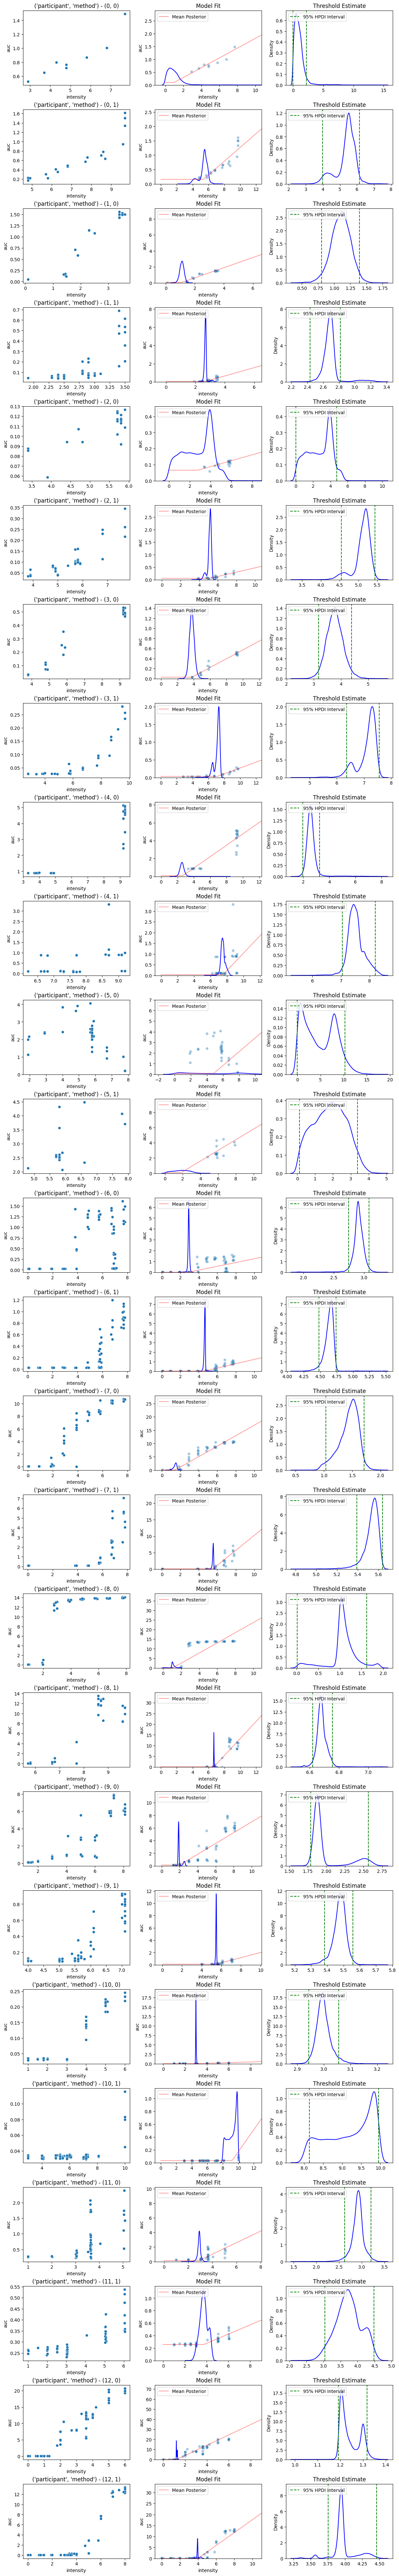

In [ ]:
model_relu.plot(df=df, posterior_samples=posterior_samples_relu);

#### Information Criterion

In [ ]:
numpyro_data_relu = az.from_numpyro(mcmc_relu)

##### Loo

In [ ]:
az.loo(numpyro_data_relu)

/home/vishu/repos/hb-mep/.venv/lib/python3.9/site-packages/arviz/stats/stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/home/vishu/repos/hb-mep/.venv/lib/python3.9/site-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/home/vishu/repos/hb-mep/.venv/lib/python3.9/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 24000 posterior samples and 1165 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   724.13    89.56
p_loo      174.16        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     1102   94.6%
 (0.5, 0.7]   (ok)         24    2.1%
   (0.7, 1]   (bad)         8    0.7%
   (1, Inf)   (very bad)   31    2.7%

##### WAIC

In [ ]:
az.waic(numpyro_data_relu)

/home/vishu/repos/hb-mep/.venv/lib/python3.9/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 24000 posterior samples and 1165 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   740.92    88.59
p_waic      157.37        -

There has been a warning during the calculation. Please check the results.

### Rectified Logistic

#### Initialize model

In [5]:
model_rectified_logistic = RectifiedLogistic(config)

#### Run MCMC inference

In [6]:
mcmc_rectified_logistic, posterior_samples_rectified_logistic = \
    model_rectified_logistic.run_inference(df=df)

2023-05-25 13:10:20,279 - jax._src.xla_bridge - INFO - Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
2023-05-25 13:10:20,279 - jax._src.xla_bridge - INFO - Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023-05-25 13:10:20,280 - jax._src.xla_bridge - INFO - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023-05-25 13:10:20,280 - jax._src.xla_bridge - INFO - Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
2023-05-25 13:10:20,281 - jax._src.xla_bridge - INFO - Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.
2023-05-25 13:10:20,315 - hb_mep.models.human.rectified_logistic - INFO - Running inference with Re

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

2023-05-25 13:25:08,604 - hb_mep.utils.utils - INFO - func:run_inference took: 14 min and 48.33 sec


#### Diagnostics

In [7]:
mcmc_rectified_logistic.print_summary(prob=.95)


                            mean       std    median      2.5%     97.5%     n_eff     r_hat
                a[0,0]      1.77      1.55      1.37      0.00      5.10   4638.81      1.00
                a[0,1]      1.35      0.08      1.34      1.20      1.53   6524.67      1.00
                a[0,2]      3.06      1.73      3.56      0.01      5.01   2889.12      1.00
                a[0,3]      4.28      0.34      4.33      3.42      4.86   1727.69      1.00
                a[0,4]      6.75      1.11      6.87      4.76      8.62   7569.22      1.00
                a[0,5]      1.24      2.78      0.85      0.00      2.09    499.31      1.00
                a[0,6]      3.23      0.18      3.21      2.95      3.60   9964.42      1.00
                a[0,7]      1.70      0.33      1.69      1.01      2.29   1517.24      1.00
                a[0,8]      1.97      0.06      1.96      1.89      2.11   3249.30      1.00
                a[0,9]      1.72      0.08      1.72      1.56      1

#### Plot fitted curves

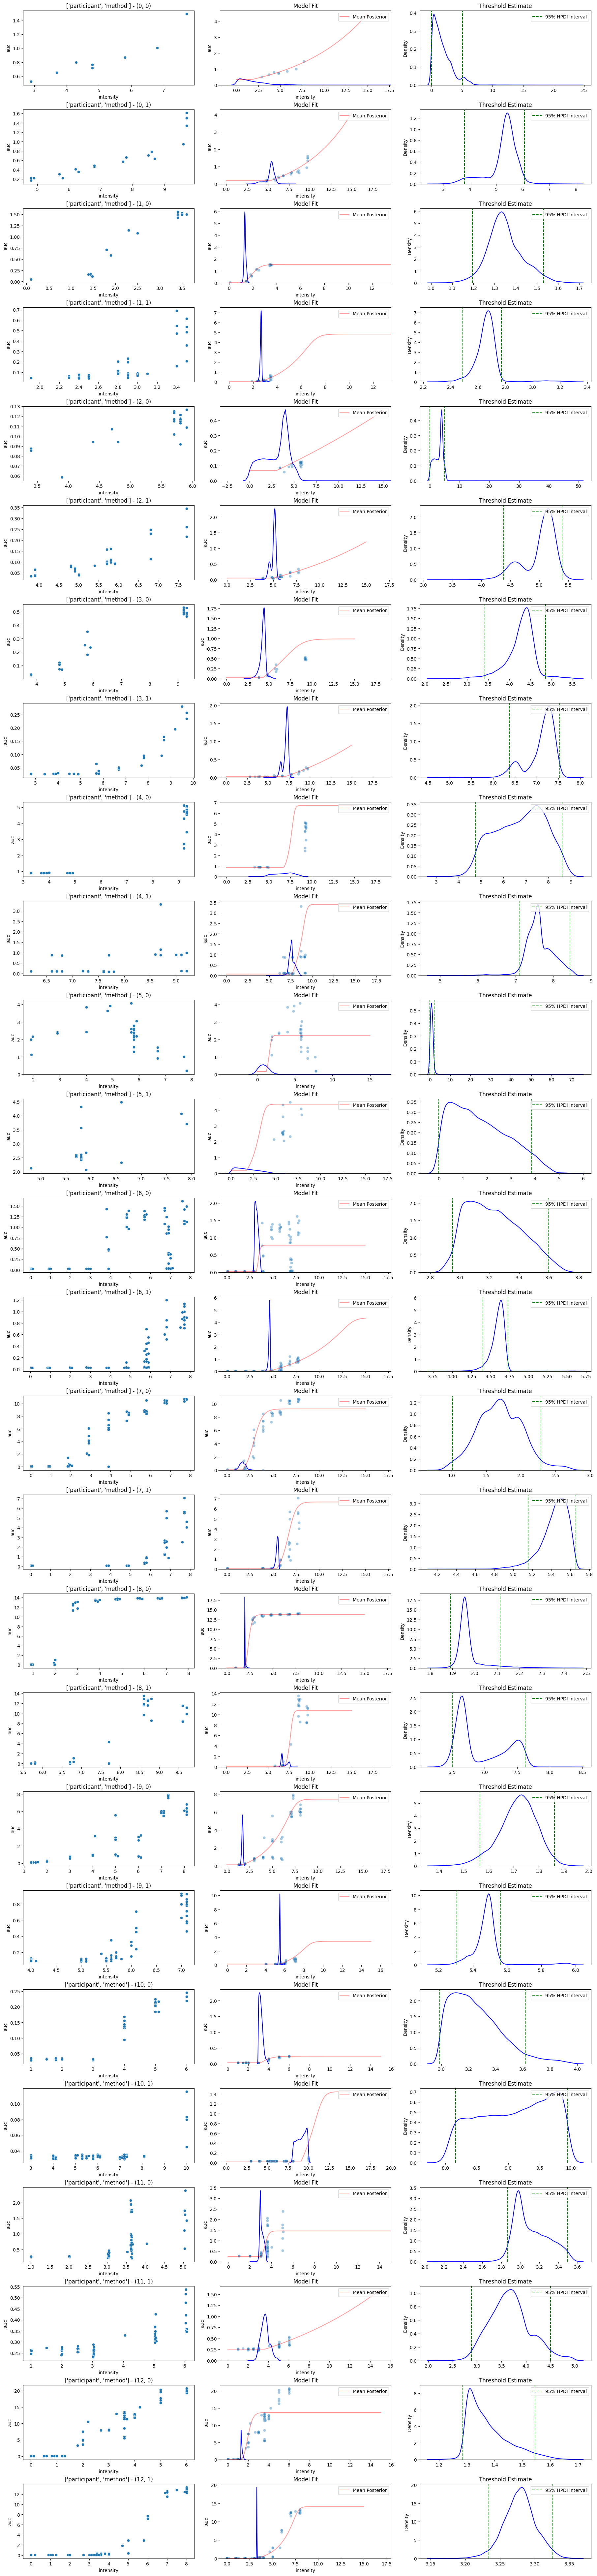

In [8]:
model_rectified_logistic.plot(df=df, posterior_samples=posterior_samples_rectified_logistic);

#### Information Criterion

In [9]:
numpyro_data_rectified_logistic = az.from_numpyro(mcmc_rectified_logistic)

##### Loo

In [10]:
az.loo(numpyro_data_rectified_logistic)

/home/vishu/repos/hb-mep/.venv/lib/python3.9/site-packages/arviz/stats/stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/home/vishu/repos/hb-mep/.venv/lib/python3.9/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 24000 posterior samples and 1165 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   954.53    89.54
p_loo      215.60        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     1104   94.8%
 (0.5, 0.7]   (ok)         28    2.4%
   (0.7, 1]   (bad)        20    1.7%
   (1, Inf)   (very bad)   13    1.1%

##### WAIC

In [11]:
az.waic(numpyro_data_rectified_logistic)

/home/vishu/repos/hb-mep/.venv/lib/python3.9/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 24000 posterior samples and 1165 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   979.82    88.11
p_waic      190.30        -

There has been a warning during the calculation. Please check the results.

### Saturated Linear

#### Initialize model

In [12]:
model_saturated_relu = SaturatedReLU(config)

#### Run MCMC inference

In [13]:
mcmc_saturated_relu, posterior_samples_saturated_relu = model_saturated_relu.run_inference(df=df)

2023-05-25 13:25:36,700 - hb_mep.models.human.saturated_relu - INFO - Running inference with Saturated_ReLU ...


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

2023-05-25 13:41:02,685 - hb_mep.utils.utils - INFO - func:run_inference took: 15 min and 25.99 sec


#### Diagnostics

In [14]:
mcmc_saturated_relu.print_summary(prob=.95)


                            mean       std    median      2.5%     97.5%     n_eff     r_hat
                a[0,0]      3.09      2.28      2.71      0.00      6.44   1179.18      1.00
                a[0,1]      1.33      0.07      1.32      1.22      1.48   4649.77      1.00
                a[0,2]      3.22      2.06      3.65      0.09      5.27    491.73      1.01
                a[0,3]      3.95      0.40      3.92      3.25      4.65    286.23      1.02
                a[0,4]      6.87      1.07      7.01      4.87      8.57   4554.92      1.00
                a[0,5]     13.58     10.02     11.93      0.00     31.52    372.00      1.01
                a[0,6]      3.28      0.20      3.26      2.98      3.67   5569.67      1.00
                a[0,7]      1.81      0.30      1.71      1.37      2.50    202.46      1.02
                a[0,8]      2.01      0.11      1.97      1.93      2.29   1516.25      1.00
                a[0,9]      2.13      0.31      1.91      1.81      2

#### Plot fitted curves

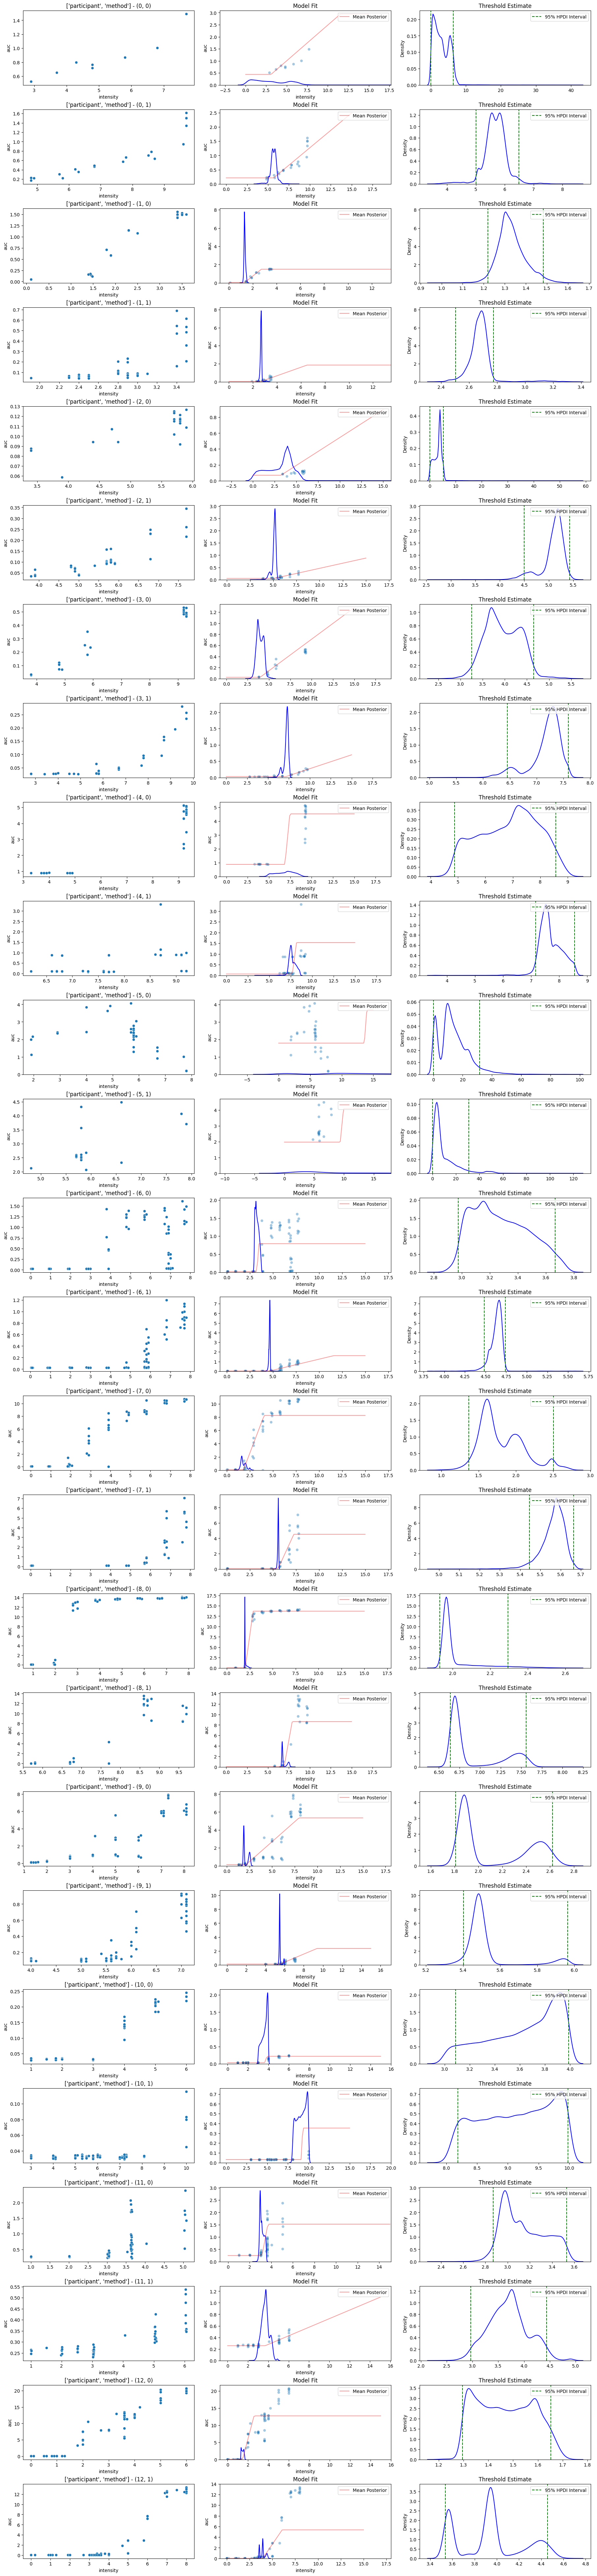

In [15]:
model_saturated_relu.plot(df=df, posterior_samples=posterior_samples_saturated_relu);

#### Information Criterion

In [16]:
numpyro_data_saturated_relu = az.from_numpyro(mcmc_saturated_relu)

##### Loo

In [17]:
az.loo(numpyro_data_saturated_relu)

/home/vishu/repos/hb-mep/.venv/lib/python3.9/site-packages/arviz/stats/stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/home/vishu/repos/hb-mep/.venv/lib/python3.9/site-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/home/vishu/repos/hb-mep/.venv/lib/python3.9/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 24000 posterior samples and 1165 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   899.64    89.32
p_loo      225.21        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     1087   93.3%
 (0.5, 0.7]   (ok)         42    3.6%
   (0.7, 1]   (bad)        17    1.5%
   (1, Inf)   (very bad)   19    1.6%

##### WAIC

In [18]:
az.waic(numpyro_data_saturated_relu)

/home/vishu/repos/hb-mep/.venv/lib/python3.9/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 24000 posterior samples and 1165 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   922.50    88.22
p_waic      202.34        -

There has been a warning during the calculation. Please check the results.

### Generalized Logistic

#### Initialize model

In [34]:
model_generalized_logistic = GeneralizedLogistic(config)

#### Run MCMC inference

In [35]:
mcmc_generalized_logistic, posterior_samples_generalized_logistic = \
    model_generalized_logistic.run_inference(df=df)

2023-05-25 14:51:41,616 - hb_mep.models.human.generalized_logistic - INFO - Running inference with Generalized_Logistic ...


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

2023-05-25 15:04:23,400 - hb_mep.utils.utils - INFO - func:run_inference took: 12 min and 41.78 sec


#### Diagnostics

In [36]:
mcmc_generalized_logistic.print_summary(prob=.95)


                            mean       std    median      2.5%     97.5%     n_eff     r_hat
                a[0,0]     11.87      2.93     11.66      6.48     18.04   2253.03      1.00
                a[0,1]      1.26      0.51      1.32      0.24      2.13   2870.13      1.00
                a[0,2]     12.33      5.57     11.47      2.61     24.90   2534.62      1.00
                a[0,3]      5.59      1.04      5.97      3.19      6.89   1314.85      1.00
                a[0,4]      7.53      1.36      7.67      4.96     10.06   1918.66      1.00
                a[0,5]     11.26      9.83      9.78      0.00     29.54   1788.71      1.00
                a[0,6]      3.29      0.30      3.33      2.72      3.81   2815.10      1.00
                a[0,7]      1.69      0.83      1.75      0.12      3.07   2868.39      1.00
                a[0,8]      1.87      0.38      1.91      1.08      2.52   2256.24      1.00
                a[0,9]      3.54      1.27      3.82      0.84      5

#### Plot fitted curves

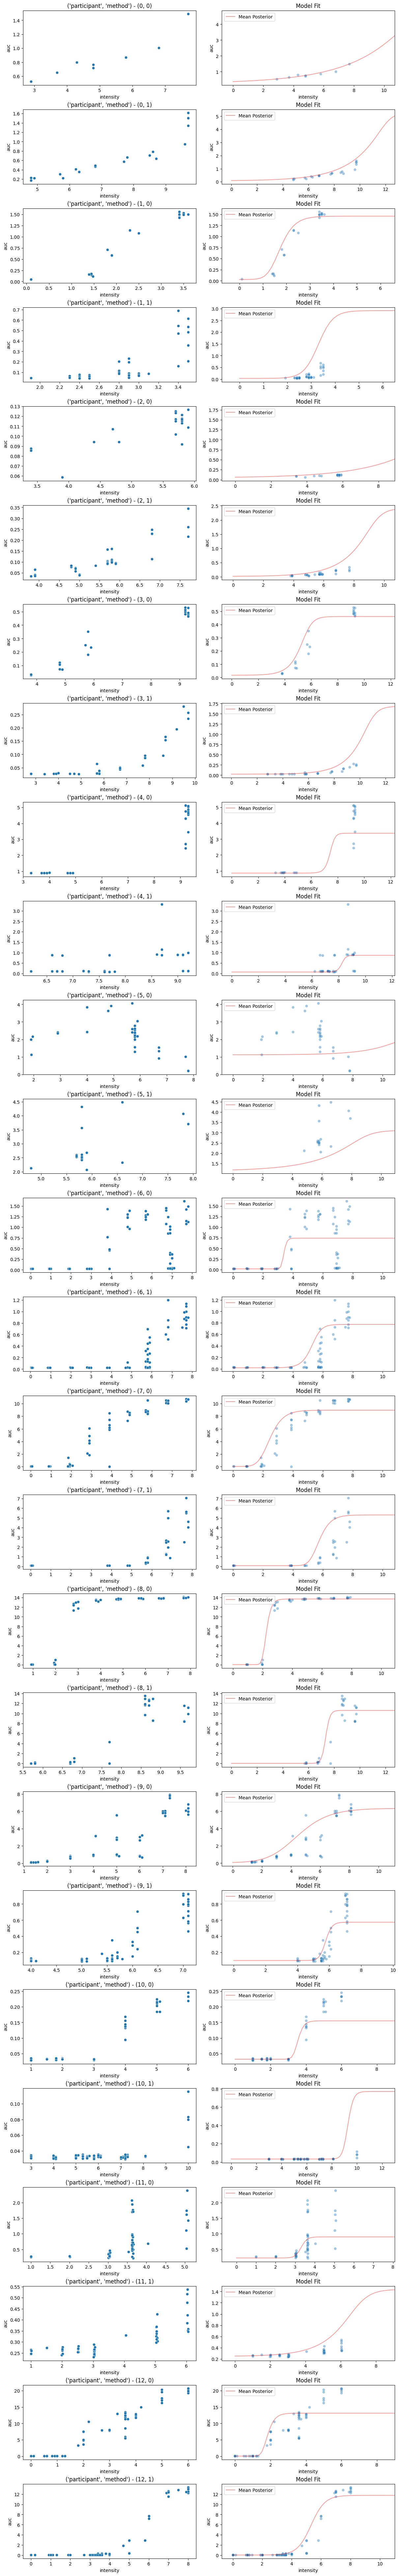

In [37]:
model_generalized_logistic.plot(df=df, posterior_samples=posterior_samples_generalized_logistic);

#### Information Criterion

In [38]:
numpyro_data_generalized_logistic = az.from_numpyro(mcmc_generalized_logistic)

##### Loo

In [39]:
az.loo(numpyro_data_generalized_logistic)

/home/vishu/repos/hb-mep/.venv/lib/python3.9/site-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/home/vishu/repos/hb-mep/.venv/lib/python3.9/site-packages/arviz/stats/stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/home/vishu/repos/hb-mep/.venv/lib/python3.9/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 24000 posterior samples and 1165 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   992.37    89.59
p_loo      198.23        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     1111   95.4%
 (0.5, 0.7]   (ok)         27    2.3%
   (0.7, 1]   (bad)        17    1.5%
   (1, Inf)   (very bad)   10    0.9%

##### WAIC

In [40]:
az.waic(numpyro_data_generalized_logistic)

/home/vishu/repos/hb-mep/.venv/lib/python3.9/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 24000 posterior samples and 1165 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  1012.50    88.30
p_waic      178.10        -

There has been a warning during the calculation. Please check the results.

### Model Comparison

In [41]:
az.compare({
    "Rectified_Logistic": numpyro_data_rectified_logistic,
    "Saturated_ReLU": numpyro_data_saturated_relu,
    "Generalized_Logistic": numpyro_data_generalized_logistic
})

/home/vishu/repos/hb-mep/.venv/lib/python3.9/site-packages/arviz/stats/stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/home/vishu/repos/hb-mep/.venv/lib/python3.9/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/vishu/repos/hb-mep/.venv/lib/python3.9/site-packages/arviz/stats/stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/home/vishu/repos/hb-mep/.venv/lib/python3.9/site-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduc

rank    elpd_loo       p_loo  elpd_diff   weight  \
Generalized_Logistic     0  992.369077  198.229926   0.000000  0.85241   
Rectified_Logistic       1  954.527689  215.599883  37.841388  0.14759   
Saturated_ReLU           2  899.637918  225.205200  92.731159  0.00000   

                             se        dse  warning scale  
Generalized_Logistic  89.586963   0.000000     True   log  
Rectified_Logistic    89.543537  11.001493     True   log  
Saturated_ReLU        89.318506  12.741863     True   log

In [42]:
az.compare({
    "Rectified_Logistic": numpyro_data_rectified_logistic,
    "Saturated_ReLU": numpyro_data_saturated_relu
})

/home/vishu/repos/hb-mep/.venv/lib/python3.9/site-packages/arviz/stats/stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/home/vishu/repos/hb-mep/.venv/lib/python3.9/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/vishu/repos/hb-mep/.venv/lib/python3.9/site-packages/arviz/stats/stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/home/vishu/repos/hb-mep/.venv/lib/python3.9/site-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduc

rank    elpd_loo       p_loo  elpd_diff    weight  \
Rectified_Logistic     0  954.527689  215.599883    0.00000  0.896087   
Saturated_ReLU         1  899.637918  225.205200   54.88977  0.103913   

                           se        dse  warning scale  
Rectified_Logistic  89.543537   0.000000     True   log  
Saturated_ReLU      89.318506  12.890379     True   log